# Install Libraries & Mount Drive

In [1]:
# mount our google drive onto colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# set oai-xray-tkr-klg to be our working directory 
import os 
os.chdir("/content/gdrive/My Drive/oai-xray-tkr-klg") 
!pwd

/content/gdrive/.shortcut-targets-by-id/1kCF2c5uonkP6JZVTqnx9Zfhbw36I73fU/oai-xray-tkr-klg


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import datetime
from PIL import Image
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score, average_precision_score
import time 
import copy

In [4]:
JPG_IMAGE_DIR = 'data/OAI_Radiographs/jpg'
OUTPUT_DIR = 'output'

# Data Loaders & Transforms

In [5]:
cropped_size = 224

train_transforms = transforms.Compose([
                                    transforms.RandomRotation(14),
                                    transforms.RandomCrop(cropped_size),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ColorJitter(hue=0.5, saturation=0.5, contrast=0.5),
                                    transforms.GaussianBlur(7, sigma=(0.1, 1.0)),
                                    transforms.ToTensor(),
                                ])

val_transforms = transforms.Compose([
                                    transforms.RandomCrop(cropped_size),
                                    transforms.ToTensor(),
                                ])

# Model Architecture

In [6]:
def get_model(tl_model, train_scratch=False, freeze_weights=True): 
  
    # load the (pretrained) model from torchvision library 
    if tl_model == "Resnet34":
        if (train_scratch):
            model_ft = models.resnet34(pretrained=False)
        else:
            model_ft = models.resnet34(pretrained=True)
    elif tl_model == "Resnet50":
        if (train_scratch):
            model_ft = models.resnet50(pretrained=False)
        else: 
            model_ft = models.resnet50(pretrained=True)
    elif tl_model == "DenseNet201":
        if (train_scratch):
            model_ft = models.densenet201(pretrained=False)
        else:
            model_ft = models.densenet201(pretrained=True)
    elif tl_model == "DenseNet169":
        if (train_scratch):
            model_ft = models.densenet169(pretrained=False)
        else:
            model_ft = models.densenet169(pretrained=True)
    elif tl_model == "DenseNet121":
        if (train_scratch):
            model_ft = models.densenet121(pretrained=False)
        else:
            model_ft = models.densenet121(pretrained=True)
    else: 
        raise ValueError(f'tl_model={tl_model} is not recognized!')

    # freeze the weights
    if freeze_weights:
      for param in model_ft.parameters():
        param.requires_grad = False

    # replace the last fc layer for binary classification 
    if tl_model in ("DenseNet201", "DenseNet169", "DenseNet121"):
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, 2)
    else:
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, 2)      

    return model_ft

# Model Training

In [7]:
def train_model(model, criterion, optimizer, num_epochs, batch_size, train_dataloader, val_dataloader, scheduler, device, file_path):

    since = time.time()
    # Initializes best variables for weights, acc, and loss
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100.0
    saved_epoch = 0

    # Creates arrays for plotting training evolution 
    loss2plot = np.zeros([num_epochs+1,2])
    acc2plot = np.zeros([num_epochs+1,2])
    auc2plot = np.zeros([num_epochs+1,2])
    auprc2plot = np.zeros([num_epochs+1,2])

    dataloaders = {'train': train_dataloader, 'val': val_dataloader}
    for epoch in tqdm(range(num_epochs+1)):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            print(f'In {phase} phase:')

            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_num_samples = 0
            running_probs = []
            running_labels = [] 

            # Iterate over data
            batch = 1 
            since_batch_start = time.time()
            for sample_batched in tqdm(dataloaders[phase], leave=False):
                inputs, labels  = sample_batched
                num_samples = len(labels)

                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype = torch.long)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) 
                    probs = torch.nn.functional.softmax(outputs, dim=1)[:,1]
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # store pred probs and labels in a list of arrays to compute AUC
                    running_probs.append(probs.cpu().detach().numpy())
                    running_labels.append(labels.cpu().detach().numpy())

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data) 
                running_num_samples += num_samples
                batch += 1
                since_batch_start = time.time()

            scheduler.step()
            
            epoch_loss = running_loss / running_num_samples
            epoch_acc = running_corrects.double() / running_num_samples

            # compute auc and auprc
            full_probs = np.concatenate(running_probs)
            full_labels = np.concatenate(running_labels)
            epoch_auc = roc_auc_score(y_true=full_labels, y_score=full_probs)
            epoch_auprc = average_precision_score(y_true=full_labels, y_score=full_probs)

            print('({} epoch {}) Loss: {:.4f} Acc: {:.4f} RocAuc: {:.4f} Auprc {:.4f}'.format(
                phase, epoch, epoch_loss, epoch_acc, epoch_auc, epoch_auprc))

            if phase == 'train':
                loss2plot[epoch,0] = epoch_loss
                acc2plot[epoch,0] = epoch_acc
                auc2plot[epoch,0] = epoch_auc
                auprc2plot[epoch,0] = epoch_auprc

            else:
                loss2plot[epoch,1] = epoch_loss
                acc2plot[epoch,1] = epoch_acc
                auc2plot[epoch,1] = epoch_auc
                auprc2plot[epoch,1] = epoch_auprc

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    # save model weights
    path = f'{file_path}/weights.pth'
    torch.save(model.state_dict(), path) 
    print(f'Model saved to {path}')

    # concat metrics and save as csv 
    metrics = pd.DataFrame(np.hstack((loss2plot, acc2plot, auc2plot, auprc2plot)), 
                          columns=['train_loss', 'val_loss', 'train_acc', 'val_acc', 'train_auc', 'val_auc', 'train_auprc', 'val_auprc'])
    metrics_path = f'{file_path}/metric_curves.csv'
    metrics.to_csv(metrics_path)

    return model, metrics

In [8]:
# params for training 
learning_rate = 1e-6
num_epochs = 100
tl_model = 'Resnet34'
train_scratch = False
batch_size = 8
num_workers = 2
l2_reg = 2
freeze_weights = False
gamma = 1
# change with each different model
base_fp = f'model_weights/{tl_model}'

In [9]:
def create_and_train_model(train_dir, val_dir):
  # get the model to use for learning
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model_ft = get_model(tl_model=tl_model, train_scratch=train_scratch, freeze_weights=freeze_weights)
  model_ft = model_ft.to(device)

  # initialize loss function and optimizer 
  loss_func = nn.CrossEntropyLoss()
  loss_func = loss_func.to(device)
  optimizer_ft = optim.Adam(model_ft.parameters(), lr=learning_rate, weight_decay=l2_reg)

  # set filepath to save weights 
  file_path = f'{base_fp}/{train_dir}'
  if not os.path.exists(file_path):
      os.makedirs(file_path)    


  train_dataset = datasets.ImageFolder(os.path.join(JPG_IMAGE_DIR, train_dir), transform=train_transforms)
  val_dataset = datasets.ImageFolder(os.path.join(JPG_IMAGE_DIR, val_dir), transform=val_transforms)

  train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
  val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

  scheduler = optim.lr_scheduler.ExponentialLR(optimizer_ft, gamma=gamma)

  return train_model(
      model=model_ft, 
      criterion=loss_func, 
      optimizer=optimizer_ft, 
      num_epochs=num_epochs, 
      batch_size=batch_size,
      train_dataloader=train_dataloader,
      val_dataloader=val_dataloader,
      scheduler=scheduler,
      device=device,
      file_path=file_path) 

In [ ]:
for fold in [1, 2, 3, 4]:
  train_dir = f'train{fold}'
  val_dir = f'val{fold}'
  create_and_train_model(train_dir, val_dir)

In [10]:
# plot training curves 

def plot_metrics(file_path, val_prefix='val'):
    full_path = f'{file_path}/metric_curves.csv'
    print(f"Plotting metrics from results stored in {full_path}")
    saved_metrics = pd.read_csv(full_path)
    saved_metrics.rename(columns={
        'val_loss': f'{val_prefix}_loss',
        'val_acc': f'{val_prefix}_acc',
        'val_auc': f'{val_prefix}_auc',
        'val_auprc': f'{val_prefix}_auprc'}, inplace=True)
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,4))
    saved_metrics[['train_loss', f'{val_prefix}_loss']].plot(ax=axes[0])
    saved_metrics[['train_acc', f'{val_prefix}_acc']].plot(ax=axes[1])
    saved_metrics[['train_auc', f'{val_prefix}_auc']].plot(ax=axes[2])
    saved_metrics[['train_auprc', f'{val_prefix}_auprc']].plot(ax=axes[3]); 

Plotting metrics from results stored in model_weights/Resnet34/train1/metric_curves.csv
Plotting metrics from results stored in model_weights/Resnet34/train2/metric_curves.csv
Plotting metrics from results stored in model_weights/Resnet34/train3/metric_curves.csv
Plotting metrics from results stored in model_weights/Resnet34/train4/metric_curves.csv


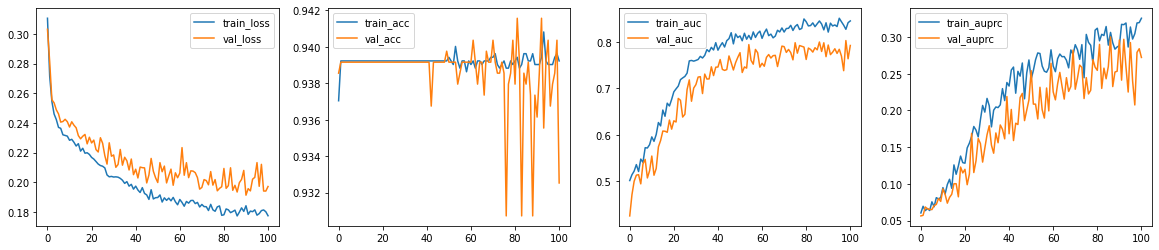

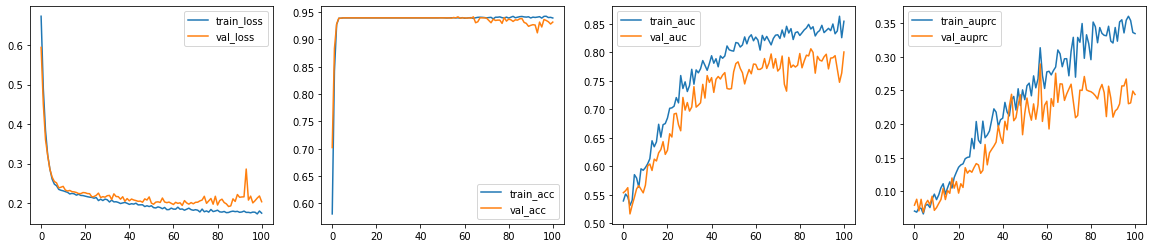

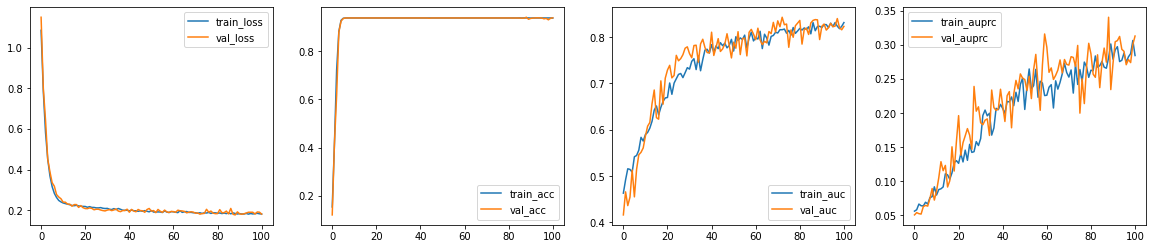

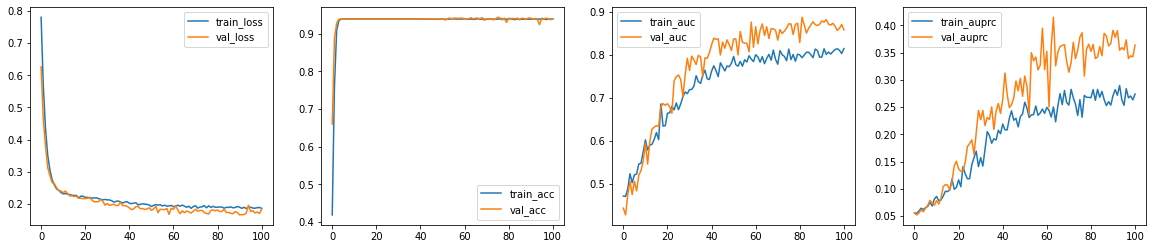

In [11]:
for fold in [1, 2, 3, 4]:
  plot_metrics(f'{base_fp}/train{fold}')



# Probability Estimates





In [12]:
def get_probs(model, wts_dir, val_img_dir, load_path):
  model.load_state_dict(torch.load(f'{load_path}/{wts_dir}/weights.pth'))
  model.eval()

  val_dataset = datasets.ImageFolder(os.path.join(JPG_IMAGE_DIR, val_img_dir), transform=val_transforms)
  val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

  probs = []

  for inputs, labels in tqdm(val_dataloader):
    inputs = inputs.to(device, dtype=torch.float)
    outputs = model(inputs)
    batch_probs = torch.nn.functional.softmax(outputs, 1)[:, 1]
    probs.extend(batch_probs.cpu().detach().numpy())
    
  fnames = os.listdir(f'{JPG_IMAGE_DIR}/{val_img_dir}/no_tkr')
  fnames.extend(os.listdir(f'{JPG_IMAGE_DIR}/{val_img_dir}/tkr'))
  fnames = [fname.split('.')[0] for fname in fnames]

  return pd.DataFrame(data=list(zip(fnames, probs)), columns=['Filename', 'TKR_Prob'])

In [13]:
load_path = base_fp
df = pd.DataFrame(columns=['Filename', 'TKR_Prob'])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = get_model(tl_model=tl_model, train_scratch=True, freeze_weights=freeze_weights)
model = model.to(device)

for fold in [1, 2, 3, 4]:
  df_fold = get_probs(model, f'train{fold}', f'val{fold}', load_path)
  df = df.append(df_fold)

df.to_csv(f'{OUTPUT_DIR}/cnn_xray_train_cv_probs.csv')

  0%|          | 0/208 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

# Test Training and Inference

In [ ]:
create_and_train_model('full_train', 'test')

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch 0/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 0) Loss: 0.3388 Acc: 0.9355 RocAuc: 0.5258 Auprc 0.0657
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 0) Loss: 0.3150 Acc: 0.9397 RocAuc: 0.5277 Auprc 0.0846

Epoch 1/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 1) Loss: 0.2763 Acc: 0.9392 RocAuc: 0.5201 Auprc 0.0642
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 1) Loss: 0.2695 Acc: 0.9388 RocAuc: 0.5232 Auprc 0.0731

Epoch 2/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 2) Loss: 0.2544 Acc: 0.9392 RocAuc: 0.5062 Auprc 0.0635
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 2) Loss: 0.2557 Acc: 0.9388 RocAuc: 0.5678 Auprc 0.0772

Epoch 3/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 3) Loss: 0.2410 Acc: 0.9392 RocAuc: 0.5523 Auprc 0.0735
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 3) Loss: 0.2437 Acc: 0.9392 RocAuc: 0.5496 Auprc 0.0749

Epoch 4/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 4) Loss: 0.2351 Acc: 0.9392 RocAuc: 0.5755 Auprc 0.0745
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 4) Loss: 0.2423 Acc: 0.9392 RocAuc: 0.5451 Auprc 0.0775

Epoch 5/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 5) Loss: 0.2324 Acc: 0.9392 RocAuc: 0.5757 Auprc 0.0817
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 5) Loss: 0.2369 Acc: 0.9392 RocAuc: 0.5675 Auprc 0.0758

Epoch 6/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 6) Loss: 0.2294 Acc: 0.9392 RocAuc: 0.5925 Auprc 0.0849
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 6) Loss: 0.2413 Acc: 0.9392 RocAuc: 0.5211 Auprc 0.0651

Epoch 7/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 7) Loss: 0.2293 Acc: 0.9392 RocAuc: 0.5850 Auprc 0.0923
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 7) Loss: 0.2318 Acc: 0.9392 RocAuc: 0.5821 Auprc 0.0971

Epoch 8/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 8) Loss: 0.2285 Acc: 0.9392 RocAuc: 0.5957 Auprc 0.0829
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 8) Loss: 0.2333 Acc: 0.9392 RocAuc: 0.5700 Auprc 0.0800

Epoch 9/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 9) Loss: 0.2254 Acc: 0.9392 RocAuc: 0.6190 Auprc 0.0977
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 9) Loss: 0.2339 Acc: 0.9392 RocAuc: 0.5856 Auprc 0.0801

Epoch 10/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 10) Loss: 0.2264 Acc: 0.9392 RocAuc: 0.6145 Auprc 0.0939
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 10) Loss: 0.2331 Acc: 0.9392 RocAuc: 0.5758 Auprc 0.0826

Epoch 11/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 11) Loss: 0.2230 Acc: 0.9392 RocAuc: 0.6451 Auprc 0.0980
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 11) Loss: 0.2302 Acc: 0.9392 RocAuc: 0.5851 Auprc 0.0900

Epoch 12/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 12) Loss: 0.2218 Acc: 0.9392 RocAuc: 0.6478 Auprc 0.1140
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 12) Loss: 0.2279 Acc: 0.9392 RocAuc: 0.6124 Auprc 0.0928

Epoch 13/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 13) Loss: 0.2221 Acc: 0.9392 RocAuc: 0.6498 Auprc 0.1069
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 13) Loss: 0.2296 Acc: 0.9392 RocAuc: 0.5987 Auprc 0.0997

Epoch 14/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 14) Loss: 0.2210 Acc: 0.9392 RocAuc: 0.6588 Auprc 0.1149
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 14) Loss: 0.2272 Acc: 0.9392 RocAuc: 0.6131 Auprc 0.0968

Epoch 15/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 15) Loss: 0.2212 Acc: 0.9392 RocAuc: 0.6548 Auprc 0.1182
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 15) Loss: 0.2255 Acc: 0.9392 RocAuc: 0.6438 Auprc 0.1134

Epoch 16/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 16) Loss: 0.2195 Acc: 0.9392 RocAuc: 0.6720 Auprc 0.1237
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 16) Loss: 0.2241 Acc: 0.9392 RocAuc: 0.6325 Auprc 0.1181

Epoch 17/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 17) Loss: 0.2143 Acc: 0.9392 RocAuc: 0.7060 Auprc 0.1482
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 17) Loss: 0.2164 Acc: 0.9392 RocAuc: 0.6845 Auprc 0.1319

Epoch 18/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 18) Loss: 0.2154 Acc: 0.9392 RocAuc: 0.6969 Auprc 0.1579
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 18) Loss: 0.2176 Acc: 0.9392 RocAuc: 0.6814 Auprc 0.1415

Epoch 19/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 19) Loss: 0.2133 Acc: 0.9392 RocAuc: 0.7142 Auprc 0.1553
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 19) Loss: 0.2169 Acc: 0.9392 RocAuc: 0.6821 Auprc 0.1408

Epoch 20/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 20) Loss: 0.2149 Acc: 0.9392 RocAuc: 0.7034 Auprc 0.1388
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 20) Loss: 0.2166 Acc: 0.9392 RocAuc: 0.6969 Auprc 0.1559

Epoch 21/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 21) Loss: 0.2101 Acc: 0.9392 RocAuc: 0.7350 Auprc 0.1560
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 21) Loss: 0.2107 Acc: 0.9392 RocAuc: 0.7220 Auprc 0.1911

Epoch 22/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 22) Loss: 0.2092 Acc: 0.9392 RocAuc: 0.7382 Auprc 0.1692
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 22) Loss: 0.2072 Acc: 0.9392 RocAuc: 0.7376 Auprc 0.2071

Epoch 23/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 23) Loss: 0.2103 Acc: 0.9392 RocAuc: 0.7309 Auprc 0.1677
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 23) Loss: 0.2119 Acc: 0.9392 RocAuc: 0.7298 Auprc 0.1783

Epoch 24/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 24) Loss: 0.2055 Acc: 0.9392 RocAuc: 0.7507 Auprc 0.2035
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 24) Loss: 0.2102 Acc: 0.9392 RocAuc: 0.7284 Auprc 0.2067

Epoch 25/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 25) Loss: 0.2066 Acc: 0.9392 RocAuc: 0.7483 Auprc 0.1829
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 25) Loss: 0.2065 Acc: 0.9392 RocAuc: 0.7440 Auprc 0.2079

Epoch 26/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 26) Loss: 0.2061 Acc: 0.9392 RocAuc: 0.7545 Auprc 0.1769
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 26) Loss: 0.2159 Acc: 0.9392 RocAuc: 0.7189 Auprc 0.1846

Epoch 27/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 27) Loss: 0.2052 Acc: 0.9392 RocAuc: 0.7507 Auprc 0.1942
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 27) Loss: 0.2031 Acc: 0.9392 RocAuc: 0.7693 Auprc 0.2141

Epoch 28/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 28) Loss: 0.2029 Acc: 0.9392 RocAuc: 0.7665 Auprc 0.2091
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 28) Loss: 0.2108 Acc: 0.9392 RocAuc: 0.7348 Auprc 0.2210

Epoch 29/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 29) Loss: 0.2013 Acc: 0.9392 RocAuc: 0.7769 Auprc 0.1964
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 29) Loss: 0.2081 Acc: 0.9392 RocAuc: 0.7558 Auprc 0.2507

Epoch 30/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 30) Loss: 0.2028 Acc: 0.9392 RocAuc: 0.7623 Auprc 0.2001
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 30) Loss: 0.2001 Acc: 0.9392 RocAuc: 0.7780 Auprc 0.2577

Epoch 31/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 31) Loss: 0.2000 Acc: 0.9392 RocAuc: 0.7721 Auprc 0.2297
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 31) Loss: 0.1958 Acc: 0.9392 RocAuc: 0.7818 Auprc 0.2706

Epoch 32/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 32) Loss: 0.2039 Acc: 0.9392 RocAuc: 0.7579 Auprc 0.2021
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 32) Loss: 0.2042 Acc: 0.9392 RocAuc: 0.7474 Auprc 0.2191

Epoch 33/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 33) Loss: 0.1978 Acc: 0.9392 RocAuc: 0.7849 Auprc 0.2245
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 33) Loss: 0.1950 Acc: 0.9392 RocAuc: 0.7932 Auprc 0.2466

Epoch 34/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 34) Loss: 0.1984 Acc: 0.9392 RocAuc: 0.7835 Auprc 0.2054
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 34) Loss: 0.1951 Acc: 0.9392 RocAuc: 0.7901 Auprc 0.2530

Epoch 35/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 35) Loss: 0.1984 Acc: 0.9392 RocAuc: 0.7803 Auprc 0.2132
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 35) Loss: 0.1934 Acc: 0.9392 RocAuc: 0.7964 Auprc 0.2488

Epoch 36/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 36) Loss: 0.1964 Acc: 0.9392 RocAuc: 0.7855 Auprc 0.2252
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 36) Loss: 0.1960 Acc: 0.9392 RocAuc: 0.7906 Auprc 0.2262

Epoch 37/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 37) Loss: 0.1960 Acc: 0.9392 RocAuc: 0.7893 Auprc 0.2191
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 37) Loss: 0.1937 Acc: 0.9392 RocAuc: 0.7987 Auprc 0.2309

Epoch 38/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 38) Loss: 0.1939 Acc: 0.9392 RocAuc: 0.7973 Auprc 0.2388
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 38) Loss: 0.2027 Acc: 0.9392 RocAuc: 0.7686 Auprc 0.2306

Epoch 39/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa7282db7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa7282db7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

(train epoch 39) Loss: 0.1925 Acc: 0.9392 RocAuc: 0.8010 Auprc 0.2532
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 39) Loss: 0.2126 Acc: 0.9392 RocAuc: 0.7448 Auprc 0.2252

Epoch 40/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 40) Loss: 0.1959 Acc: 0.9392 RocAuc: 0.7890 Auprc 0.2152
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 40) Loss: 0.2246 Acc: 0.9392 RocAuc: 0.7496 Auprc 0.2161

Epoch 41/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 41) Loss: 0.1934 Acc: 0.9392 RocAuc: 0.7961 Auprc 0.2347
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 41) Loss: 0.1957 Acc: 0.9392 RocAuc: 0.7905 Auprc 0.2454

Epoch 42/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 42) Loss: 0.1907 Acc: 0.9392 RocAuc: 0.8058 Auprc 0.2538
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 42) Loss: 0.1985 Acc: 0.9397 RocAuc: 0.7752 Auprc 0.2261

Epoch 43/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 43) Loss: 0.1944 Acc: 0.9391 RocAuc: 0.7879 Auprc 0.2423
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 43) Loss: 0.2117 Acc: 0.9397 RocAuc: 0.7482 Auprc 0.2332

Epoch 44/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 44) Loss: 0.1935 Acc: 0.9392 RocAuc: 0.7932 Auprc 0.2498
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 44) Loss: 0.2033 Acc: 0.9397 RocAuc: 0.7737 Auprc 0.2330

Epoch 45/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 45) Loss: 0.1932 Acc: 0.9392 RocAuc: 0.7928 Auprc 0.2445
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 45) Loss: 0.2002 Acc: 0.9397 RocAuc: 0.7739 Auprc 0.2131

Epoch 46/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 46) Loss: 0.1906 Acc: 0.9392 RocAuc: 0.8085 Auprc 0.2399
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 46) Loss: 0.2011 Acc: 0.9401 RocAuc: 0.7824 Auprc 0.2294

Epoch 47/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 47) Loss: 0.1886 Acc: 0.9391 RocAuc: 0.8127 Auprc 0.2633
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 47) Loss: 0.2057 Acc: 0.9374 RocAuc: 0.7904 Auprc 0.2288

Epoch 48/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 48) Loss: 0.1876 Acc: 0.9392 RocAuc: 0.8133 Auprc 0.2692
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 48) Loss: 0.2006 Acc: 0.9383 RocAuc: 0.7786 Auprc 0.2270

Epoch 49/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 49) Loss: 0.1909 Acc: 0.9392 RocAuc: 0.8066 Auprc 0.2398
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 49) Loss: 0.1915 Acc: 0.9401 RocAuc: 0.8025 Auprc 0.3012

Epoch 50/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 50) Loss: 0.1880 Acc: 0.9392 RocAuc: 0.8142 Auprc 0.2664
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 50) Loss: 0.2002 Acc: 0.9392 RocAuc: 0.7659 Auprc 0.2291

Epoch 51/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 51) Loss: 0.1909 Acc: 0.9394 RocAuc: 0.8055 Auprc 0.2456
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 51) Loss: 0.2038 Acc: 0.9401 RocAuc: 0.7841 Auprc 0.2327

Epoch 52/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 52) Loss: 0.1914 Acc: 0.9397 RocAuc: 0.7948 Auprc 0.2644
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 52) Loss: 0.1947 Acc: 0.9392 RocAuc: 0.7898 Auprc 0.2383

Epoch 53/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 53) Loss: 0.1911 Acc: 0.9392 RocAuc: 0.8025 Auprc 0.2498
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 53) Loss: 0.1954 Acc: 0.9392 RocAuc: 0.7923 Auprc 0.2309

Epoch 54/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 54) Loss: 0.1900 Acc: 0.9395 RocAuc: 0.8026 Auprc 0.2663
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 54) Loss: 0.2058 Acc: 0.9280 RocAuc: 0.7976 Auprc 0.2664

Epoch 55/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 55) Loss: 0.1889 Acc: 0.9401 RocAuc: 0.8087 Auprc 0.2776
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 55) Loss: 0.1963 Acc: 0.9383 RocAuc: 0.7912 Auprc 0.2541

Epoch 56/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 56) Loss: 0.1884 Acc: 0.9395 RocAuc: 0.8117 Auprc 0.2700
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 56) Loss: 0.1969 Acc: 0.9397 RocAuc: 0.7837 Auprc 0.2446

Epoch 57/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 57) Loss: 0.1884 Acc: 0.9394 RocAuc: 0.8103 Auprc 0.2683
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 57) Loss: 0.1995 Acc: 0.9383 RocAuc: 0.7660 Auprc 0.2450

Epoch 58/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 58) Loss: 0.1886 Acc: 0.9394 RocAuc: 0.8102 Auprc 0.2664
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 58) Loss: 0.1926 Acc: 0.9388 RocAuc: 0.8255 Auprc 0.2585

Epoch 59/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 59) Loss: 0.1877 Acc: 0.9397 RocAuc: 0.8123 Auprc 0.2835
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 59) Loss: 0.1943 Acc: 0.9392 RocAuc: 0.7899 Auprc 0.2401

Epoch 60/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 60) Loss: 0.1858 Acc: 0.9391 RocAuc: 0.8191 Auprc 0.2848
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 60) Loss: 0.1953 Acc: 0.9392 RocAuc: 0.8011 Auprc 0.2586

Epoch 61/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 61) Loss: 0.1883 Acc: 0.9395 RocAuc: 0.8074 Auprc 0.2805
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 61) Loss: 0.1956 Acc: 0.9374 RocAuc: 0.7929 Auprc 0.2563

Epoch 62/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 62) Loss: 0.1860 Acc: 0.9386 RocAuc: 0.8217 Auprc 0.2797
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 62) Loss: 0.1927 Acc: 0.9392 RocAuc: 0.8018 Auprc 0.2644

Epoch 63/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 63) Loss: 0.1889 Acc: 0.9391 RocAuc: 0.8046 Auprc 0.2556
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 63) Loss: 0.1901 Acc: 0.9374 RocAuc: 0.8099 Auprc 0.3047

Epoch 64/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 64) Loss: 0.1851 Acc: 0.9386 RocAuc: 0.8156 Auprc 0.2838
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 64) Loss: 0.1945 Acc: 0.9338 RocAuc: 0.8089 Auprc 0.2947

Epoch 65/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 65) Loss: 0.1852 Acc: 0.9386 RocAuc: 0.8196 Auprc 0.2887
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 65) Loss: 0.2043 Acc: 0.9392 RocAuc: 0.7719 Auprc 0.2561

Epoch 66/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 66) Loss: 0.1885 Acc: 0.9394 RocAuc: 0.8032 Auprc 0.2848
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 66) Loss: 0.1899 Acc: 0.9405 RocAuc: 0.8009 Auprc 0.2748

Epoch 67/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 67) Loss: 0.1855 Acc: 0.9394 RocAuc: 0.8166 Auprc 0.2871
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 67) Loss: 0.2264 Acc: 0.9195 RocAuc: 0.8178 Auprc 0.2687

Epoch 68/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 68) Loss: 0.1831 Acc: 0.9398 RocAuc: 0.8264 Auprc 0.2967
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 68) Loss: 0.1967 Acc: 0.9325 RocAuc: 0.7951 Auprc 0.2778

Epoch 69/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 69) Loss: 0.1852 Acc: 0.9389 RocAuc: 0.8166 Auprc 0.2702
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 69) Loss: 0.1911 Acc: 0.9405 RocAuc: 0.8043 Auprc 0.2906

Epoch 70/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 70) Loss: 0.1843 Acc: 0.9392 RocAuc: 0.8209 Auprc 0.2893
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 70) Loss: 0.1950 Acc: 0.9392 RocAuc: 0.7829 Auprc 0.2963

Epoch 71/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 71) Loss: 0.1824 Acc: 0.9389 RocAuc: 0.8174 Auprc 0.3091
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 71) Loss: 0.1939 Acc: 0.9356 RocAuc: 0.8044 Auprc 0.2754

Epoch 72/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 72) Loss: 0.1848 Acc: 0.9392 RocAuc: 0.8207 Auprc 0.2898
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 72) Loss: 0.1919 Acc: 0.9397 RocAuc: 0.7933 Auprc 0.2645

Epoch 73/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 73) Loss: 0.1842 Acc: 0.9398 RocAuc: 0.8260 Auprc 0.2968
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 73) Loss: 0.1923 Acc: 0.9361 RocAuc: 0.7987 Auprc 0.2792

Epoch 74/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 74) Loss: 0.1856 Acc: 0.9389 RocAuc: 0.8130 Auprc 0.2894
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 74) Loss: 0.2228 Acc: 0.9222 RocAuc: 0.7917 Auprc 0.2708

Epoch 75/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 75) Loss: 0.1877 Acc: 0.9392 RocAuc: 0.8054 Auprc 0.2809
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 75) Loss: 0.1951 Acc: 0.9325 RocAuc: 0.8106 Auprc 0.3187

Epoch 76/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 76) Loss: 0.1837 Acc: 0.9392 RocAuc: 0.8194 Auprc 0.2935
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 76) Loss: 0.1986 Acc: 0.9405 RocAuc: 0.7840 Auprc 0.2850

Epoch 77/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 77) Loss: 0.1843 Acc: 0.9392 RocAuc: 0.8240 Auprc 0.2897
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 77) Loss: 0.2008 Acc: 0.9347 RocAuc: 0.8086 Auprc 0.2964

Epoch 78/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 78) Loss: 0.1831 Acc: 0.9391 RocAuc: 0.8197 Auprc 0.3072
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 78) Loss: 0.2012 Acc: 0.9401 RocAuc: 0.7921 Auprc 0.2953

Epoch 79/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 79) Loss: 0.1816 Acc: 0.9394 RocAuc: 0.8267 Auprc 0.3122
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 79) Loss: 0.1986 Acc: 0.9401 RocAuc: 0.8037 Auprc 0.2949

Epoch 80/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 80) Loss: 0.1852 Acc: 0.9392 RocAuc: 0.8127 Auprc 0.2993
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 80) Loss: 0.1861 Acc: 0.9397 RocAuc: 0.8165 Auprc 0.3142

Epoch 81/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 81) Loss: 0.1825 Acc: 0.9392 RocAuc: 0.8322 Auprc 0.2930
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 81) Loss: 0.2079 Acc: 0.9410 RocAuc: 0.7738 Auprc 0.2725

Epoch 82/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 82) Loss: 0.1853 Acc: 0.9392 RocAuc: 0.8240 Auprc 0.2780
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 82) Loss: 0.1949 Acc: 0.9397 RocAuc: 0.7951 Auprc 0.2660

Epoch 83/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 83) Loss: 0.1822 Acc: 0.9391 RocAuc: 0.8240 Auprc 0.3133
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 83) Loss: 0.2108 Acc: 0.9437 RocAuc: 0.7979 Auprc 0.2964

Epoch 84/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 84) Loss: 0.1837 Acc: 0.9392 RocAuc: 0.8196 Auprc 0.3016
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 84) Loss: 0.1943 Acc: 0.9356 RocAuc: 0.8173 Auprc 0.3042

Epoch 85/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 85) Loss: 0.1826 Acc: 0.9392 RocAuc: 0.8230 Auprc 0.3017
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 85) Loss: 0.1909 Acc: 0.9405 RocAuc: 0.8135 Auprc 0.3007

Epoch 86/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 86) Loss: 0.1823 Acc: 0.9392 RocAuc: 0.8267 Auprc 0.2976
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 86) Loss: 0.2025 Acc: 0.9321 RocAuc: 0.8032 Auprc 0.2720

Epoch 87/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 87) Loss: 0.1874 Acc: 0.9392 RocAuc: 0.8188 Auprc 0.2583
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 87) Loss: 0.1911 Acc: 0.9392 RocAuc: 0.8103 Auprc 0.2835

Epoch 88/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 88) Loss: 0.1842 Acc: 0.9392 RocAuc: 0.8183 Auprc 0.2856
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 88) Loss: 0.1931 Acc: 0.9298 RocAuc: 0.8164 Auprc 0.2510

Epoch 89/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 89) Loss: 0.1839 Acc: 0.9392 RocAuc: 0.8291 Auprc 0.2800
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 89) Loss: 0.1950 Acc: 0.9347 RocAuc: 0.8118 Auprc 0.2834

Epoch 90/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 90) Loss: 0.1821 Acc: 0.9392 RocAuc: 0.8304 Auprc 0.3091
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 90) Loss: 0.2135 Acc: 0.9347 RocAuc: 0.8062 Auprc 0.2926

Epoch 91/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 91) Loss: 0.1813 Acc: 0.9392 RocAuc: 0.8344 Auprc 0.2987
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 91) Loss: 0.1952 Acc: 0.9370 RocAuc: 0.8103 Auprc 0.2794

Epoch 92/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 92) Loss: 0.1833 Acc: 0.9392 RocAuc: 0.8204 Auprc 0.2906
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 92) Loss: 0.1963 Acc: 0.9365 RocAuc: 0.7925 Auprc 0.2929

Epoch 93/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 93) Loss: 0.1844 Acc: 0.9392 RocAuc: 0.8201 Auprc 0.2958
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 93) Loss: 0.2041 Acc: 0.9392 RocAuc: 0.7712 Auprc 0.2791

Epoch 94/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 94) Loss: 0.1829 Acc: 0.9391 RocAuc: 0.8281 Auprc 0.2846
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 94) Loss: 0.1924 Acc: 0.9392 RocAuc: 0.7978 Auprc 0.2688

Epoch 95/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 95) Loss: 0.1848 Acc: 0.9392 RocAuc: 0.8166 Auprc 0.2954
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 95) Loss: 0.1940 Acc: 0.9392 RocAuc: 0.7972 Auprc 0.2915

Epoch 96/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 96) Loss: 0.1834 Acc: 0.9392 RocAuc: 0.8308 Auprc 0.2919
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 96) Loss: 0.1884 Acc: 0.9392 RocAuc: 0.8027 Auprc 0.2836

Epoch 97/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 97) Loss: 0.1817 Acc: 0.9392 RocAuc: 0.8310 Auprc 0.2898
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 97) Loss: 0.1934 Acc: 0.9392 RocAuc: 0.8042 Auprc 0.2700

Epoch 98/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 98) Loss: 0.1827 Acc: 0.9392 RocAuc: 0.8234 Auprc 0.2946
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 98) Loss: 0.1943 Acc: 0.9329 RocAuc: 0.8058 Auprc 0.2864

Epoch 99/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 99) Loss: 0.1831 Acc: 0.9392 RocAuc: 0.8288 Auprc 0.2899
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 99) Loss: 0.1883 Acc: 0.9397 RocAuc: 0.8335 Auprc 0.2907

Epoch 100/100
----------
In train phase:


  0%|          | 0/837 [00:00<?, ?it/s]

(train epoch 100) Loss: 0.1806 Acc: 0.9392 RocAuc: 0.8367 Auprc 0.3036
In val phase:


  0%|          | 0/280 [00:00<?, ?it/s]

(val epoch 100) Loss: 0.2102 Acc: 0.9423 RocAuc: 0.7925 Auprc 0.3053

Training complete in 209m 53s
Model saved to model_weights/Resnet34/hundred_epochs_2_l2_reg/full_train/weights.pth


(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU

In [14]:
df = pd.DataFrame(columns=['Filename', 'TKR_Prob'])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = get_model(tl_model=tl_model, train_scratch=True, freeze_weights=freeze_weights)
model = model.to(device)

get_probs(model, 'full_train', 'test', load_path).to_csv(f'{OUTPUT_DIR}/cnn_xray_test_preds.csv')

  0%|          | 0/280 [00:00<?, ?it/s]

Plotting metrics from results stored in model_weights/Resnet34/full_train/metric_curves.csv


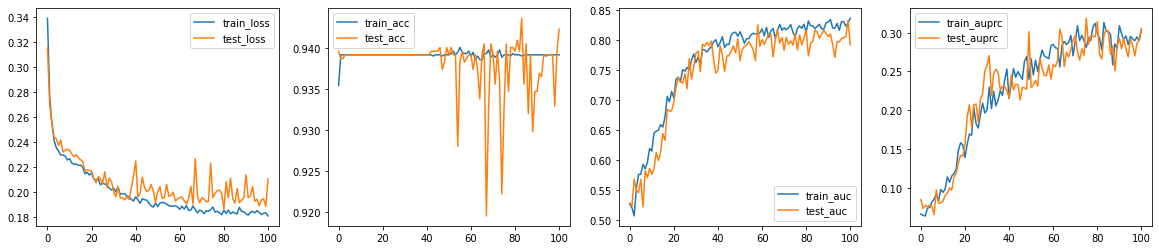

In [15]:
plot_metrics(f'{base_fp}/full_train', val_prefix='test')